**Forecast for the next six months, after the last date of the data, the sum of visitors of all 
the restaurants and validate the accuracy of your forecast. You can solve this question 
using the tool that you prefer.**

### skforecast

In [1]:
# data
# ==============================================================================
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import yaml, requests, re, string, random, psycopg2

# plot pretty figures
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# forecast
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# hide warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

In [4]:
q = """
    select 
            *
    from
            kaggle_data.didi.restaurants_visitors;      
"""

In [5]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)

C:\Users\migue\AppData\Local\Temp/ipykernel_12932/2654062988.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(sql = q, con = db_conn_post)


add the name of the day

In [6]:
df_raw['day_of_week'] = df_raw['visit_date'].dt.day_name()

In [7]:
df_raw.head(1)

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors,day_of_week
0,db80363d35f10926,2016-01-01,2016-01-01,2016-01-01 01:00:00,5,Friday


In [8]:
columns = ['visit_date', 'reserve_visitors']
df = df_raw[columns].set_index('visit_date')

In [9]:
df.head(3)

,reserve_visitors
visit_date,
2016-01-01,5
2016-01-02,2
2016-01-02,4


In [10]:
df = df.resample('D').sum()

In [11]:
(df.index == pd.date_range(start=df.index.min(),
                           end=df.index.max(),
                           freq=df.index.freq)).all()

True

In [12]:
df.isnull().sum()

reserve_visitors    0
dtype: int64

In [13]:
print(f"Rows with missing values: {df.isnull().any(axis=1).mean()}")

Rows with missing values: 0.0


In [14]:
print('min date: ', df.index.min())
print('max date: ', df.index.max())

min date:  2016-01-01 00:00:00
max date:  2017-05-31 00:00:00


In [15]:
df.head(1)

,reserve_visitors
visit_date,
2016-01-01,5


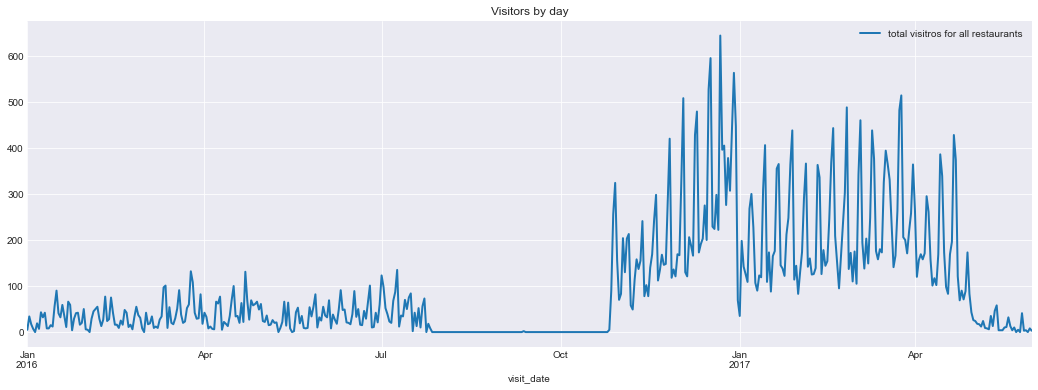

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))
df['reserve_visitors'].plot(ax=ax, label='total visitros for all restaurants', linewidth=2, linestyle = '-')
ax.set_title('Visitors by day')
ax.legend();

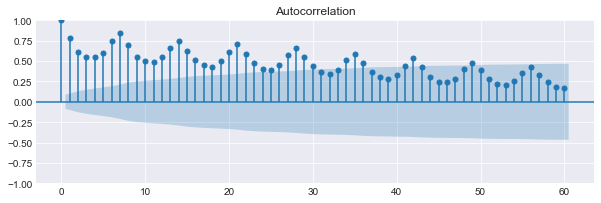

In [17]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(df['reserve_visitors'], ax=ax, lags=60)
plt.show()

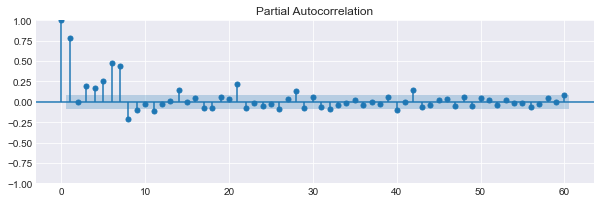

In [18]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(df['reserve_visitors'], ax=ax, lags=60, method = 'ywm')
plt.show()

In [19]:
df_train = df.loc[:'2016-12-31']

In [20]:
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(),
                 lags          = 30,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y = df_train['reserve_visitors'])
forecaster

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 30 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-07-02 16:28:27 
Last fit date: 2023-07-02 16:28:27 
Skforecast version: 0.8.1 
Python version: 3.9.6 
Forecaster id: None 

In [21]:
metric, pred = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = df_train['reserve_visitors'],
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            initial_train_size = 90,
                            refit              = False,
                            verbose            = True,
                            show_progress      = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 90
Number of observations used for backtesting: 276
    Number of folds: 276
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2016-03-30 00:00:00  (n=90)
    Validation: 2016-03-31 00:00:00 -- 2016-03-31 00:00:00  (n=1)
Fold: 1
    Training:   2016-01-01 00:00:00 -- 2016-03-30 00:00:00  (n=90)
    Validation: 2016-04-01 00:00:00 -- 2016-04-01 00:00:00  (n=1)
Fold: 2
    Training:   2016-01-01 00:00:00 -- 2016-03-30 00:00:00  (n=90)
    Validation: 2016-04-02 00:00:00 -- 2016-04-02 00:00:00  (n=1)
Fold: 3
    Training:   2016-01-01 00:00:00 -- 2016-03-30 00:00:00  (n=90)
    Validation: 2016-04-03 00:00:00 -- 2016-04-03 00:00:00  (n=1)
Fold: 4
    Training:   2016-01-01 00:00:00 -- 2016-03-30 00:00:00  (n=90)
    Validation: 2016-04-04 00:00:00 -- 2016-04-0

  0%|          | 0/276 [00:00<?, ?it/s]

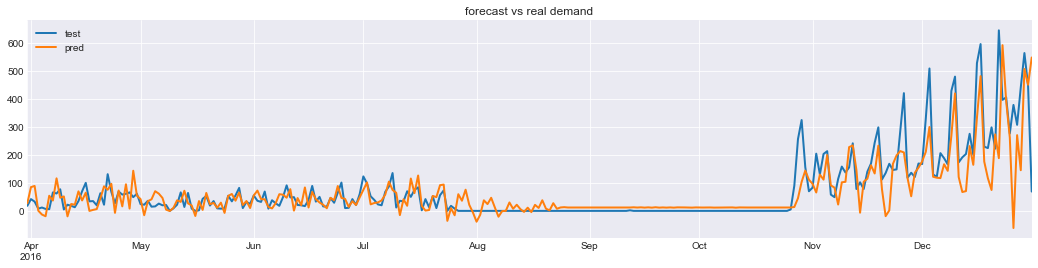

In [22]:
fig, ax = plt.subplots(figsize=(18, 4))
df.loc[pred.index, 'reserve_visitors'].plot(ax=ax, linewidth=2, label='test')
pred.plot(linewidth=2, label='forecast', ax=ax)
ax.set_title('forecast vs real demand')
ax.legend();

In [23]:
print(f'Error backtest(MAE): {metric}')

Error backtest(MAE): 38.23981724074997


In [24]:
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(),
                 lags          = 30, # Este valor será remplazado en el grid search
                 transformer_y = StandardScaler()
             )

# Lags utilizados como predictores
lags_grid = [7, 14, 30]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                      forecaster         = forecaster,
                      y                  = df['reserve_visitors'],
                      steps              = 1,
                      metric             = 'mean_absolute_error',
                      param_grid         = param_grid,
                      lags_grid          = lags_grid,
                      initial_train_size = 90,
                      refit              = False,
                      return_best        = True,
                      verbose            = False
                  )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 43.62959856319342



In [25]:
results_grid

,lags,params,mean_absolute_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.001},43.629599,0.001000
1,"[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.007742636826811269},43.630782,0.007743
2,"[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.05994842503189409},43.639954,0.059948
3,"[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.46415888336127775},43.717019,0.464159
4,"[1, 2, 3, 4, 5, 6, 7]",{'alpha': 3.593813663804626},44.496996,3.593814
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.46415888336127775},47.244114,0.464159
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.05994842503189409},47.311355,0.059948
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.007742636826811269},47.323000,0.007743
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.001},47.324528,0.001000
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 3.593813663804626},47.443561,3.593814


In [26]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=0.001) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 00:00:00'), Timestamp('2017-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-07-02 16:28:30 
Last fit date: 2023-07-02 16:29:11 
Skforecast version: 0.8.1 
Python version: 3.9.6 
Forecaster id: None 

  0%|          | 0/427 [00:00<?, ?it/s]

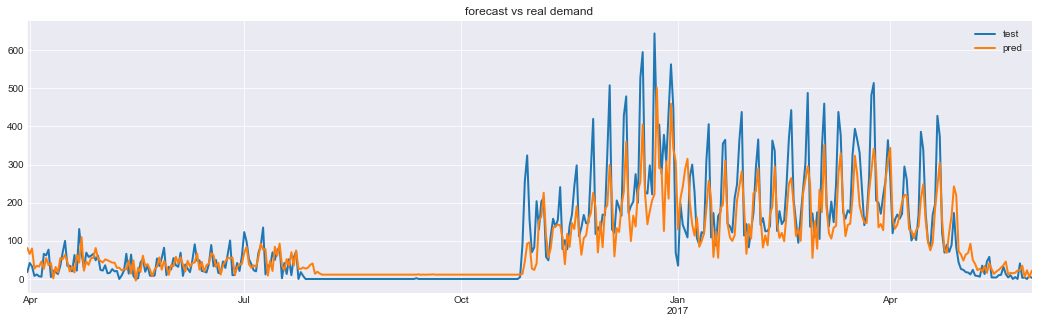

In [27]:
metric, pred = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = df['reserve_visitors'],
                            steps              = 1,
                            metric             = mean_absolute_error,
                            initial_train_size = 90,
                            refit              = False,
                            verbose            = False,
                            show_progress      = True
                        )


fig, ax = plt.subplots(figsize=(18, 5))
df.loc[pred.index, 'reserve_visitors'].plot(linewidth=2, label='test', ax=ax)
pred.plot(linewidth=2, label='forecast', ax=ax)
ax.set_title('forecast vs real demand')
ax.legend();

In [28]:
print(f'Error backtest(MAE): {metric}')

Error backtest(MAE): 43.62959856319342


In [29]:
df_pred = pd.DataFrame(forecaster.predict(183))

In [30]:
df_forecast = pd.concat([df, df_pred], axis = 1)

In [31]:
df_forecast.tail(1)

,reserve_visitors,pred
2017-11-30,NaN,69.80908


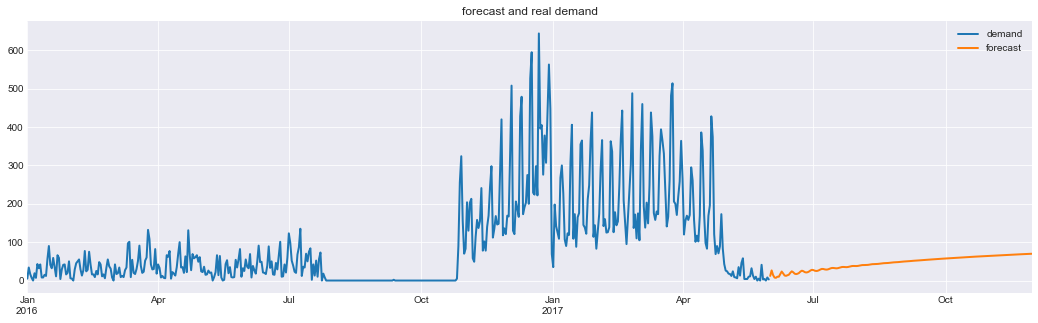

In [32]:
fig, ax = plt.subplots(figsize=(18, 5))
df_forecast['reserve_visitors'].plot(linewidth=2, label='demand', ax=ax)
df_forecast['pred'].plot(linewidth=2, label='forecast', ax=ax)
ax.set_title('forecast and real demand')
ax.legend();

**the first approach with sklearn doesn't predict as I like, now I'll try with ARIMA model**

### ARIMA

In [33]:
# library

import sys, yaml, psycopg2, os, itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats import descriptivestats
from sqlalchemy import create_engine

# preatty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings('ignore')

In [34]:
df_a = df_raw[['visit_date', 'reserve_visitors']]

In [35]:
df_a.set_index('visit_date', inplace = True)

In [43]:
y = df_a.resample('D').sum()

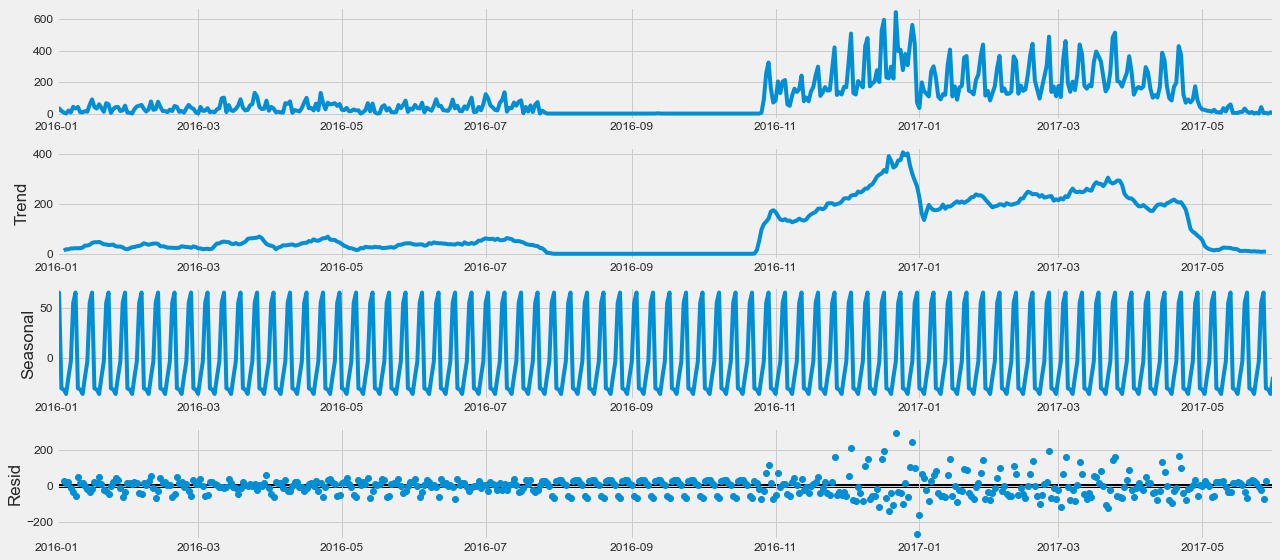

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

In [38]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [39]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationary = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6679.916166910303
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6448.620629431709
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6235.992432641637
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6113.21424957309
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6306.126617355447
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6241.563908713516
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6174.46125551855
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6114.030843024567
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6288.8553462387235
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6172.764704046936
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6085.533460587176
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5922.831389114512
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6104.853021126016
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6042.396770042333
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6002.278198174034
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5921.431488245991
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5996.864758995262
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5984.2853653571365
ARIMA(0, 1

In [45]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order = (1, 1, 1),
                                seasonal_order = (1, 1, 1, 12),
                                enforce_stationary = False,
                                enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4028      0.036     11.095      0.000       0.332       0.474
ma.L1         -0.8902      0.022    -41.377      0.000      -0.932      -0.848
ar.S.L12      -0.1190      0.030     -3.903      0.000      -0.179      -0.059
ma.S.L12      -1.0000      0.035    -28.962      0.000      -1.068      -0.932
sigma2      4984.4138   6.93e-06    7.2e+08      0.000    4984.414    4984.414


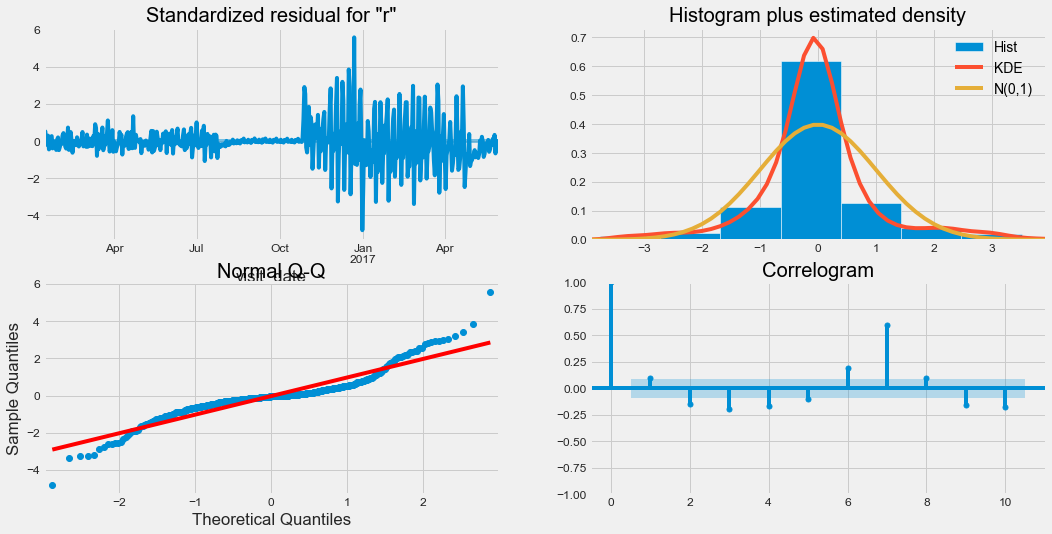

In [46]:
results.plot_diagnostics(figsize = (16,8))
plt.show()

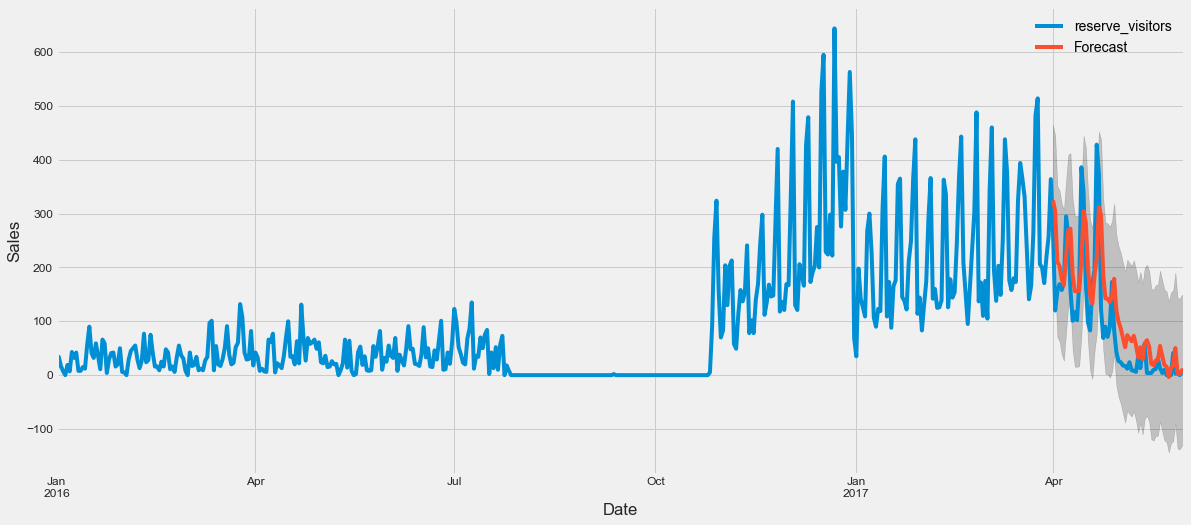

In [49]:
pred = results.get_prediction(start = pd.to_datetime('2017-04-01'), 
                              dynamic=False)
pred_ci = pred.conf_int()

ax = y['2016':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = "Forecast")

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [51]:
y_forecasted = pred.predicted_mean
y_truth = y.loc['2017-04-01':, 'reserve_visitors']

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4827.01


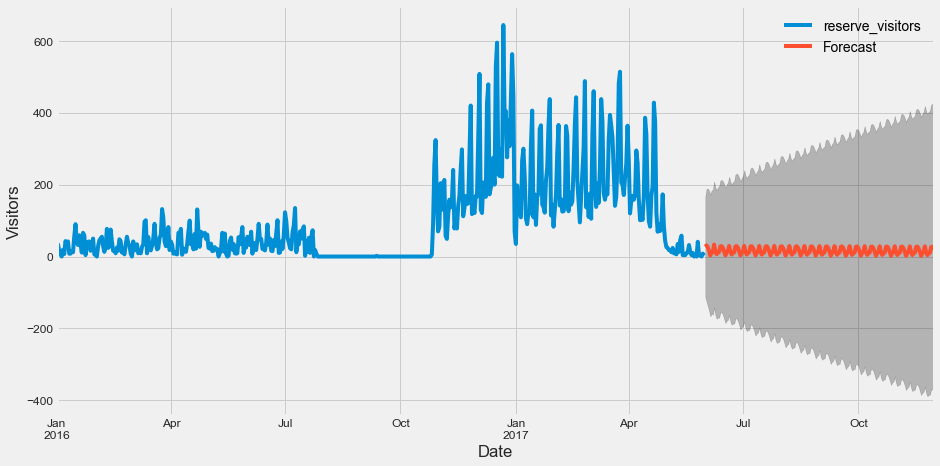

In [53]:
pred_uc = results.get_forecast(steps=183)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')

plt.legend()
plt.show()

The two models initially showed promising results, but their performance declined when attempting to predict the next six months. An alternative approach could involve aggregating the data on a monthly basis rather than a daily basis. This would provide a broader perspective and potentially improve the model's predictive capabilities.

Additionally, incorporating additional features such as weather conditions, consumer confidence index, holidays, and other relevant factors could enhance the model's accuracy. Weather conditions can influence consumer behavior and affect the demand for delivery services. The consumer confidence index provides insights into the overall sentiment and willingness to spend, which can impact app usage. Holidays and special events can also have a significant influence on user behavior and may require specific strategies or promotions to retain users during those periods.

By including these additional features, the model can capture the impact of external factors. 